In [1]:
# Importar módulos personalizados
import sys
import os

# Agregar la ruta de los módulos LGBM
sys.path.append('../lgbm')

import pred_lgbm as pred
import funciones_lgbm as f_lgbm

e:\PWC\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================================
# ENSEMBLE MODEL PARA PREDICCIÓN DE SALARIOS 
# ============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict  # ← AGREGADO cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression  # ← AGREGADO LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Importar módulos personalizados
try:
    import pred_lgbm as pred
    import funciones_lgbm as f_lgbm
    print("✅ Módulos personalizados cargados correctamente")
except ImportError as e:
    print(f"⚠️ No se pudieron cargar algunos módulos: {e}")

# ============================================================================
# STACKING 
# ============================================================================

def create_stacking_ensemble(results, X_train, y_train, X_test, y_test, scaler):
    """
    Crea un ensemble Stacking 
    """
    print(" Creando ensemble STACKING ...")
    
    # Obtener modelos válidos
    valid_models = {name: res for name, res in results.items() if res['r2'] > 0}
    print(f" Modelos para stacking: {list(valid_models.keys())}")
    
    # NIVEL 1: Generar predicciones 
    print("   📊 Generando predicciones ...")
    meta_features_train = []
    meta_features_test = []
    
    for name, result in valid_models.items():
        model = result['model']
        
        # Usar datos apropiados según el modelo
        if name in ['Ridge', 'ElasticNet']:
            X_tr_scaled = scaler.transform(X_train)
            X_te_scaled = scaler.transform(X_test)
            X_tr, X_te = X_tr_scaled, X_te_scaled
        else:
            X_tr, X_te = X_train, X_test
        
        
        #ver función from sklearn.ensemble import StackingRegressor diferencias
        
        # Predicciones  para train 
        if name != 'LightGBM_Base':  # Modelos entrenados
            oof_predictions = cross_val_predict(model, X_tr, y_train, cv=5, method='predict')
        else:  # Modelo pre-entrenado
            oof_predictions = cross_val_predict(model, X_tr, y_train, cv=5, method='predict')
        
        # Predicciones para test
        test_predictions = model.predict(X_te)
        
        meta_features_train.append(oof_predictions)
        meta_features_test.append(test_predictions)
        
        print(f"      ✅ {name}: OOF shape {oof_predictions.shape}, Test shape {test_predictions.shape}")
    
    # Combinar features del meta-modelo
    meta_X_train = np.column_stack(meta_features_train)
    meta_X_test = np.column_stack(meta_features_test)
    
    print(f"   📊 Meta-features shape - Train: {meta_X_train.shape}, Test: {meta_X_test.shape}")
    
    # NIVEL 2: Entrenar meta-modelo
    print("  Entrenando meta-modelo...")
    
    # Probar varios meta-modelos
    meta_models = {
        'Ridge': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'LinearRegression': LinearRegression()
    }
    
    best_meta_model = None
    best_meta_score = float('inf')
    best_meta_name = None
    
    for meta_name, meta_model in meta_models.items():
        try:
            # Entrenar meta-modelo
            meta_model.fit(meta_X_train, y_train)
            
            # Predecir en test
            meta_predictions = meta_model.predict(meta_X_test)
            
            # Evaluar
            meta_rmse = np.sqrt(mean_squared_error(y_test, meta_predictions))
            meta_r2 = r2_score(y_test, meta_predictions)
            
            print(f"      {meta_name}: RMSE=${meta_rmse:,.2f}, R²={meta_r2:.3f}")
            
            if meta_rmse < best_meta_score:
                best_meta_score = meta_rmse
                best_meta_model = meta_model
                best_meta_name = meta_name
                best_predictions = meta_predictions
                
        except Exception as e:
            print(f"      ❌ Error con {meta_name}: {e}")
    
    if best_meta_model is None:
        print("   ❌ No se pudo entrenar ningún meta-modelo")
        return None
    
    print(f"   🏆 Mejor meta-modelo: {best_meta_name} (RMSE: ${best_meta_score:,.2f})")
    
    # Crear diccionario del stacking ensemble
    stacking_dict = {
        'individual_models': {name: res['model'] for name, res in valid_models.items()},
        'meta_model': best_meta_model,
        'meta_model_name': best_meta_name,
        'model_names': list(valid_models.keys()),
        'ensemble_type': 'stacking',
        'scaler': scaler,
        'meta_features_columns': len(valid_models),  # Para verificación
        'level1_models': list(valid_models.keys()),
        'predictions': best_predictions,
        'rmse': best_meta_score,
        'r2': r2_score(y_test, best_predictions),
        'mae': mean_absolute_error(y_test, best_predictions)
    }
    
    print(f"   ✅ Stacking ensemble creado exitosamente")
    print(f"      🎯 RMSE: ${stacking_dict['rmse']:,.2f}")
    print(f"      📈 R²: {stacking_dict['r2']:.3f}")
    
    return stacking_dict

def save_stacking_model(stacking_ensemble, model_package, filename="../../../modelos/ensemble_stacking.pkl"):
    """
    Guarda el ensemble stacking con formato compatible
    """
    print("💾 Guardando ensemble STACKING...")
    
    if stacking_ensemble is None:
        print("❌ No hay ensemble stacking para guardar")
        return False
    
    # Crear paquete compatible
    compatible_package = {
        'model': stacking_ensemble,  # Diccionario con todo el stacking
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'has_statistical_features': True,
        'is_ensemble': True,
        'ensemble_type': 'stacking',  # Flag específico para stacking
        
        # Claves adicionales necesarias
        'total_features': model_package.get('total_features', len(model_package['feature_names'])),
        'training_data_shape': model_package.get('training_data_shape', None),
        'model_name': 'Stacking_Ensemble',
        'metrics': {
            'rmse': stacking_ensemble['rmse'],
            'r2': stacking_ensemble['r2'],
            'mae': stacking_ensemble['mae']
        }
    }
    
    try:
        joblib.dump(compatible_package, filename)
        print(f"✅ Stacking ensemble guardado en: {filename}")
        print(f"   🎯 Meta-modelo: {stacking_ensemble['meta_model_name']}")
        print(f"   🤖 Modelos nivel 1: {len(stacking_ensemble['level1_models'])}")
        return True
    except Exception as e:
        print(f"❌ Error guardando stacking: {e}")
        return False

def predict_stacking_ensemble(input_data, ensemble_package):
    """
    Función de predicción específica para stacking ensemble
    """
    try:
        print("🎯 Predicción con STACKING ensemble...")
        
        # Obtener componentes del stacking
        stacking_components = ensemble_package['model']
        individual_models = stacking_components['individual_models']
        meta_model = stacking_components['meta_model']
        scaler = stacking_components.get('scaler')
        
        # Crear grupos si no existen
        input_data_copy = input_data.copy()
        if 'Exp_group' not in input_data_copy.columns or 'Age_group' not in input_data_copy.columns:
            for idx, row in input_data_copy.iterrows():
                exp_group, age_group = calculate_groups(
                    age=row['Age'], 
                    years_of_experience=row['Years_of_Experience'], 
                    grouping_info=ensemble_package['grouping_info']
                )
                input_data_copy.at[idx, 'Exp_group'] = exp_group
                input_data_copy.at[idx, 'Age_group'] = age_group
        
        # Crear features
        X_features, _ = create_features_with_stats_pred(
            input_data_copy,
            all_job_categories=ensemble_package['job_categories'],
            all_seniority_levels=ensemble_package['seniority_categories'],
            stats_dict=ensemble_package['stats_dict']
        )
        
        # NIVEL 1: Predicciones de modelos base
        level1_predictions = []
        
        for name, model in individual_models.items():
            try:
                if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                    X_scaled = scaler.transform(X_features)
                    pred = model.predict(X_scaled)[0]
                else:
                    pred = model.predict(X_features)[0]
                
                level1_predictions.append(pred)
                
            except Exception as e:
                print(f"⚠️ Error con modelo {name}: {e}")
                continue
        
        if not level1_predictions:
            print("❌ No se pudieron generar predicciones nivel 1")
            return None
        
        # NIVEL 2: Meta-modelo
        meta_features = np.array(level1_predictions).reshape(1, -1)
        final_prediction = meta_model.predict(meta_features)[0]
        
        print(f"   🤖 Predicciones nivel 1: {level1_predictions}")
        print(f"   🧠 Meta-predicción: ${final_prediction:,.2f}")
        
        return final_prediction
        
    except Exception as e:
        print(f"❌ Error en predicción stacking: {e}")
        return None

def ensemble_predict(X, individual_models, weights=None, scaler=None):
    """
    Función que hace predicciones de ensemble sin usar clases
    """
    predictions = []
    
    for name, model in individual_models.items():
        try:
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X)
                pred = model.predict(X_scaled)
            else:
                pred = model.predict(X)
            
            predictions.append(pred)
            
        except Exception as e:
            print(f"⚠️ Error prediciendo con {name}: {e}")
            continue
    
    if not predictions:
        raise ValueError("No se pudieron hacer predicciones")
    
    # Combinar predicciones
    if weights is not None and len(weights) == len(predictions):
        result = np.average(predictions, axis=0, weights=weights)
    else:
        result = np.mean(predictions, axis=0)
    
    return result

def save_ensemble_compatible(ensemble_results, model_results, model_package, X_train, y_train, scaler):
    """
    Guarda el ensemble SIN CLASES usando tu función save_with_stats
    """
    print("💾 Guardando ensemble compatible...")
    
    # Identificar mejor ensemble
    best_ensemble_name = min(ensemble_results.keys(), key=lambda x: ensemble_results[x]['rmse'])
    best_ensemble = ensemble_results[best_ensemble_name]
    
    print(f"   🏆 Mejor ensemble: {best_ensemble['method']}")
    print(f"   📊 RMSE: ${best_ensemble['rmse']:,.2f}")
    print(f"   📈 R²: {best_ensemble['r2']:.3f}")
    
    # En lugar de una clase, guardar los componentes del ensemble
    ensemble_components = {
        'individual_models': {name: result['model'] for name, result in model_results.items()},
        'weights': best_ensemble.get('weights', None),
        'models_used': best_ensemble.get('models_used', list(model_results.keys())),
        'scaler': scaler,
        'ensemble_type': best_ensemble['method'],
        'ensemble_metrics': {
            'rmse': best_ensemble['rmse'],
            'r2': best_ensemble['r2'],
            'mae': best_ensemble['mae']
        }
    }
    
    # Usar el MISMO formato que tu función save_with_stats
    complete_package = {
        'model': ensemble_components,  # ← Los componentes en lugar de la clase
        'model_name': f'Ensemble_{best_ensemble_name}_WithStats',
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'total_features': len(model_package['feature_names']),
        'training_data_shape': X_train.shape,
        'has_statistical_features': True,
        'is_ensemble': True,  # Flag para identificar que es ensemble
        'metrics': ensemble_components['ensemble_metrics']
    }
    
    # Guardar en archivo SEPARADO (no sobreescribir original)
    ensemble_filename = "../../../modelos/ensemble.pkl"  # ← NUEVO ARCHIVO
    
    try:
        joblib.dump(complete_package, ensemble_filename)
        print(f"   ✅ Ensemble guardado en: {ensemble_filename}")
        print(f"   📱 Archivo original NO modificado")
        print(f"   🔄 FORMATO: Compatible con tu función save_with_stats")
        
        return complete_package
        
    except Exception as e:
        print(f"   ❌ Error guardando ensemble: {e}")
        return None



# ============================================================================
# FUNCIONES PRINCIPALES
# ============================================================================

def load_model_and_data():
    """Carga el modelo base y los datos"""
    print("🔄 Cargando modelo y datos...")
    
    try:
        model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
        print("✅ Modelo cargado")
    except Exception as e:
        print(f"❌ Error cargando modelo: {e}")
        return None, None
    
    try:
        data = pd.read_csv('../../../dataC/imputado.csv')
        data = data.dropna()
        print(f"✅ Datos cargados: {data.shape}")
        return model_package, data
    except Exception as e:
        print(f"❌ Error cargando datos: {e}")
        return model_package, None

def prepare_data(data, model_package):
    """Prepara los datos para el ensemble"""
    print("🔧 Preparando datos...")
    
    data_copy = data.copy()
    
    # Crear grupos
    for idx, row in data_copy.iterrows():
        exp_group, age_group = pred.calculate_groups(
            age=row['Age'], 
            years_of_experience=row['Years_of_Experience'], 
            grouping_info=model_package['grouping_info']
        )
        data_copy.at[idx, 'Exp_group'] = exp_group
        data_copy.at[idx, 'Age_group'] = age_group
    
    # Separar features y target
    X_data = data_copy.drop('Salary', axis=1)
    y = data_copy['Salary']
    
    # Crear features
    X_features, _ = f_lgbm.create_features_with_stats(
        X_data,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )
    
    print(f"✅ Features preparadas: {X_features.shape}")
    return X_features, y

def create_models(base_model):
    """Crea los modelos para el ensemble"""
    print(" Creando modelos...")
    
    models = {
        'LightGBM': base_model,
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    
    print(f"✅ {len(models)} modelos creados")
    return models

def train_models(models, X_train, y_train, X_test, y_test):
    """Entrena los modelos"""
    print("🚀 Entrenando modelos...")
    
    results = {}
    
    for name, model in models.items():
        print(f"Entrenando {name}...")
        
        try:
            if name != 'LightGBM':
                model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            results[name] = {
                'model': model,
                'rmse': rmse,
                'r2': r2,
                'predictions': y_pred
            }
            
            print(f"   RMSE: ${rmse:,.0f} | R²: {r2:.3f}")
            
        except Exception as e:
            print(f"   ❌ Error: {e}")
    
    return results

def create_ensemble(results, y_test):
    """Crea el ensemble SIN CLASES"""
    print(" Creando ensemble...")
    
    # Calcular pesos basados en R²
    valid_models = {name: res for name, res in results.items() if res['r2'] > 0}
    r2_scores = [res['r2'] for res in valid_models.values()]
    weights = np.array(r2_scores)
    weights = weights / weights.sum()
    
    # Crear diccionario del ensemble (NO clase)
    ensemble_dict = {
        'individual_models': {name: res['model'] for name, res in valid_models.items()},
        'weights': weights.tolist(),
        'model_names': list(valid_models.keys()),
        'ensemble_type': 'weighted'
    }
    
    print(f"✅ Ensemble creado con {len(valid_models)} modelos")
    return ensemble_dict

def save_compatible_model(ensemble, model_package, filename):
    """Guarda el ensemble con formato compatible SIN CLASES"""
    print("💾 Guardando modelo compatible...")
    
    # NO usar clases, solo diccionarios y funciones
    # Incluir TODAS las claves que espera pred.predict()
    compatible_package = {
        'model': ensemble,  # ensemble como diccionario, no como clase
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'has_statistical_features': True,
        'is_ensemble': True,  # Flag para identificar ensemble
        
        # CLAVES ADICIONALES que espera pred.predict()
        'total_features': model_package.get('total_features', len(model_package['feature_names'])),
        'training_data_shape': model_package.get('training_data_shape', None),
        'model_name': f'Ensemble_Model',
        'metrics': model_package.get('metrics', {})
    }
    
    try:
        joblib.dump(compatible_package, filename)
        print(f"✅ Guardado en: {filename}")
        return True
    except Exception as e:
        print(f"❌ Error guardando: {e}")
        return False

def main():
    """Función principal que crea AMBOS ensembles: Voting y Stacking"""
    print("🚀 INICIANDO PIPELINE DE ENSEMBLE DUAL")
    print("="*50)
    
    # 1. Cargar datos
    model_package, data = load_model_and_data()
    if model_package is None or data is None:
        print("❌ No se pudieron cargar los datos")
        return
    
    # 2. Preparar datos
    X, y = prepare_data(data, model_package)
    
    # 3. Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    
    # 4. Escalar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 5. Crear modelos
    models = create_models(model_package['model'])
    
    # 6. Entrenar modelos
    results = train_models(models, X_train, y_train, X_test, y_test)
    
    print("\n" + "="*60)
    print(" CREANDO ENSEMBLE VOTING")
    print("="*60)
    
    # 7. Crear ensemble Voting
    voting_ensemble = create_ensemble(results, y_test)
    
    # 8. Guardar ensemble Voting
    voting_saved = save_compatible_model(voting_ensemble, model_package, "../../../modelos/ensemble_voting2.pkl")
    
    print("\n" + "="*60)
    print(" CREANDO ENSEMBLE STACKING")
    print("="*60)
    
    # 9. Crear ensemble Stacking
    stacking_ensemble = create_stacking_ensemble(results, X_train, y_train, X_test, y_test, scaler)
    
    # 10. Guardar ensemble Stacking
    stacking_saved = save_stacking_model(stacking_ensemble, model_package)
    
    print("\n" + "="*60)
    print("📊 COMPARACIÓN DE ENSEMBLES")
    print("="*60)
    
    # 11. Comparar resultados
    if voting_ensemble and stacking_ensemble:
        print(" VOTING ENSEMBLE:")
        print(f"   Método: Promedio ponderado por R²")
        print(f"   Modelos: {len(voting_ensemble['individual_models'])}")
        # Calcular métricas para voting
        voting_predictions = []
        voting_weights = voting_ensemble.get('weights', [])
        for i, (name, model) in enumerate(voting_ensemble['individual_models'].items()):
            if name in ['Ridge', 'ElasticNet']:
                pred = model.predict(X_test_scaled)
            else:
                pred = model.predict(X_test)
            voting_predictions.append(pred)
        
        if voting_weights and len(voting_weights) == len(voting_predictions):
            voting_final = np.average(voting_predictions, axis=0, weights=voting_weights)
        else:
            voting_final = np.mean(voting_predictions, axis=0)
        
        voting_rmse = np.sqrt(mean_squared_error(y_test, voting_final))
        voting_r2 = r2_score(y_test, voting_final)
        
        print(f"   RMSE: ${voting_rmse:,.2f}")
        print(f"   R²: {voting_r2:.3f}")
        
        print("\n STACKING ENSEMBLE:")
        print(f"   Método: Meta-modelo ({stacking_ensemble['meta_model_name']})")
        print(f"   Modelos nivel 1: {len(stacking_ensemble['level1_models'])}")
        print(f"   RMSE: ${stacking_ensemble['rmse']:,.2f}")
        print(f"   R²: {stacking_ensemble['r2']:.3f}")
        
        # Determinar ganador
        if stacking_ensemble['rmse'] < voting_rmse:
            print(f"\n🏆 GANADOR: STACKING (mejora de ${voting_rmse - stacking_ensemble['rmse']:,.2f} en RMSE)")
        else:
            print(f"\n🏆 GANADOR: VOTING (mejora de ${stacking_ensemble['rmse'] - voting_rmse:,.2f} en RMSE)")
    
    print("\n PIPELINE DUAL COMPLETADO!")
    print("✅ Dos ensembles creados:")
    print("   • ensemble_voting2.pkl (Promedio ponderado)")
    print("   • ensemble_stacking.pkl (Meta-modelo)")
    

if __name__ == "__main__":
    main()

✅ Módulos personalizados cargados correctamente
🚀 INICIANDO PIPELINE DE ENSEMBLE DUAL
🔄 Cargando modelo y datos...
✅ Modelo cargado
✅ Datos cargados: (366, 9)
🔧 Preparando datos...
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (PREDICT)...
   📥 Usando estadísticas pre-calculadas de TRAIN...
   ✅ Creadas 32 features estadísticos para producción
✅ Features totales para producción: 102
   - Originales: 70
   - Estadísticos: 32
✅ Features preparadas: (366, 102)
Train: (292, 102), Test: (74, 102)
 Creando modelos...
✅ 4 modelos creados
🚀 Entrenando modelos...
Entrenando LightGBM...
   RMSE: $15,871 | R²: 0.905
Entrenando XGBoost...
   RMSE: $19,065 |

## Ensambles estratificados

In [ ]:
# 
# ============================================================================
# ENSEMBLE MODEL CON GROUPKFold Y VOTING POR FOLDS
# ============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')



def create_models(base_model):
    """Crea modelos base para ensemble"""
    print("⚙️ Creando modelos...")
    models = {
        'LightGBM': base_model,
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    return models

def train_models(models, X_train, y_train, X_test, y_test):
    """Entrena modelos individuales"""
    results = {}
    for name, model in models.items():
        print(f"🚀 Entrenando {name}...")
        if name != 'LightGBM':
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred
        }
        print(f"   ✅ RMSE: ${rmse:,.2f} | R²: {r2:.3f}")
    return results

# ============================================================================
# NUEVAS FUNCIONES PARA GROUPKFOLD
# ============================================================================

def train_models_group_folds(models, X, y, groups, n_splits=3, scaler=None):
    """Entrena modelos en folds definidos por grupos"""
    print("🔄 Entrenando modelos con GroupKFold...")
    gkf = GroupKFold(n_splits=n_splits)
    all_results = []

    for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n==== Fold {i+1}/{n_splits} ====")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado opcional
        if scaler is not None:
            scaler_fold = StandardScaler()
            X_train_scaled = scaler_fold.fit_transform(X_train)
            X_test_scaled = scaler_fold.transform(X_test)
        else:
            X_train_scaled, X_test_scaled, scaler_fold = X_train, X_test, None

        results_fold = train_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

        all_results.append({
            'results': results_fold,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler_fold
        })

    print("\n✅ Entrenamiento por folds completado")
    return all_results

def ensemble_group_predictions(all_results, method='mean'):
    """Combina predicciones finales de los folds"""
    print("\n🎯 Creando ensemble final de folds...")

    combined_preds = []
    combined_true = []

    for fold_data in all_results:
        fold_preds = []
        y_test = fold_data['y_test']
        X_test = fold_data['X_test']
        results = fold_data['results']
        scaler = fold_data['scaler']

        for name, res in results.items():
            model = res['model']
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X_test)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test)
            fold_preds.append(preds)

        if method == 'mean':
            fold_final = np.mean(fold_preds, axis=0)
        elif method == 'median':
            fold_final = np.median(fold_preds, axis=0)
        else:
            raise ValueError("Método no soportado. Usa 'mean' o 'median'.")

        combined_preds.append(fold_final)
        combined_true.append(y_test.values)

    final_preds = np.concatenate(combined_preds)
    final_true = np.concatenate(combined_true)

    rmse = np.sqrt(mean_squared_error(final_true, final_preds))
    r2 = r2_score(final_true, final_preds)

    print(f"✅ Ensemble final: RMSE=${rmse:,.2f}, R²={r2:.3f}")
    return final_preds, final_true, rmse, r2

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    print("🚀 INICIANDO PIPELINE CON GROUPKFOLD Y VOTING FINAL")
    print("="*60)

    # ========================
    # Cargar datos y modelo base
    # ========================
    model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
    data = pd.read_csv('../../../dataC/imputado.csv').dropna()

    print(f"✅ Datos cargados: {data.shape}")

    # ========================
    # Preparar grupos y features
    # ========================
    for idx, row in data.iterrows():
        exp_group, age_group = pred.calculate_groups(
            age=row['Age'], 
            years_of_experience=row['Years_of_Experience'], 
            grouping_info=model_package['grouping_info']
        )
        data.at[idx, 'Exp_group'] = exp_group
        data.at[idx, 'Age_group'] = age_group

    X = data.drop('Salary', axis=1)
    y = data['Salary']

    X_features, _ = f_lgbm.create_features_with_stats(
        X,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )

    groups = data['Exp_group']

    # ========================
    # Crear y entrenar modelos
    # ========================
    models = create_models(model_package['model'])

    all_results = train_models_group_folds(models, X_features, y, groups=groups, n_splits=3, scaler=None)

    # ========================
    # Ensemble final por folds
    # ========================
    final_preds, final_true, final_rmse, final_r2 = ensemble_group_predictions(all_results, method='mean')

    print("\n🏆 RESULTADO FINAL:")
    print(f"   RMSE: ${final_rmse:,.2f}")
    print(f"   R²: {final_r2:.3f}")

    print("\n✅ PIPELINE COMPLETADO")




In [4]:
main()

🚀 INICIANDO PIPELINE CON GROUPKFOLD Y VOTING FINAL
✅ Datos cargados: (366, 9)
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (PREDICT)...
   📥 Usando estadísticas pre-calculadas de TRAIN...
   ✅ Creadas 32 features estadísticos para producción
✅ Features totales para producción: 102
   - Originales: 70
   - Estadísticos: 32
⚙️ Creando modelos...
🔄 Entrenando modelos con GroupKFold...

==== Fold 1/3 ====
🚀 Entrenando LightGBM...
   ✅ RMSE: $7,486.06 | R²: 0.895
🚀 Entrenando XGBoost...
   ✅ RMSE: $26,307.85 | R²: -0.291
🚀 Entrenando RandomForest...
   ✅ RMSE: $27,548.11 | R²: -0.416
🚀 Entrenando CatBoost...
   ✅ RMSE: $22,293.95 | R²: 0.073

==== F

🚀 INICIANDO PIPELINE CON GROUPKFOLD, VOTING FINAL, GRÁFICOS Y GUARDADO
✅ Datos cargados: (366, 9)
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (PREDICT)...
   📥 Usando estadísticas pre-calculadas de TRAIN...
   ✅ Creadas 32 features estadísticos para producción
✅ Features totales para producción: 102
   - Originales: 70
   - Estadísticos: 32
⚙️ Creando modelos...
🔄 Entrenando modelos con GroupKFold...

==== Fold 1/3 ====
🚀 Entrenando LightGBM...
   ✅ RMSE: $7,486.06 | R²: 0.895
🚀 Entrenando XGBoost...
   ✅ RMSE: $26,307.85 | R²: -0.291
🚀 Entrenando RandomForest...
   ✅ RMSE: $27,548.11 | R²: -0.416
🚀 Entrenando CatBoost...
   ✅ RMSE: $22,293.95

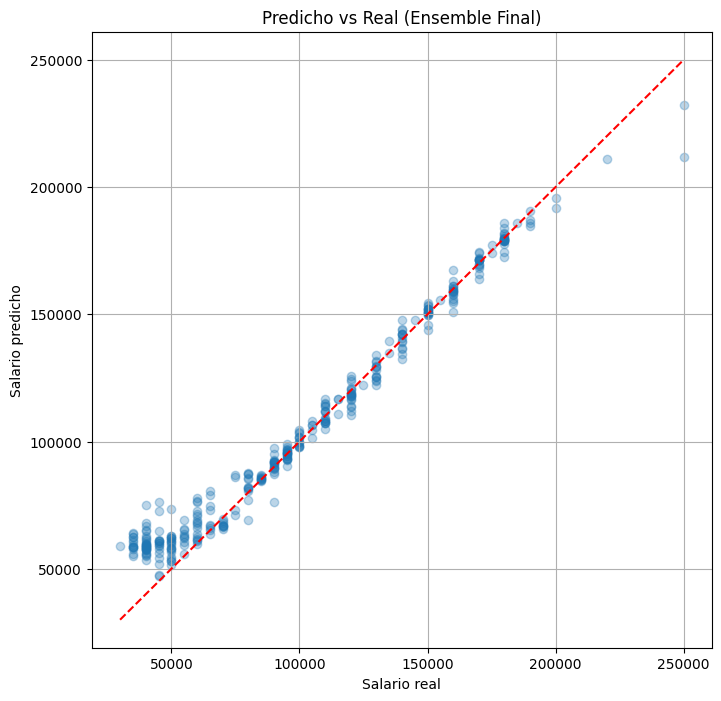

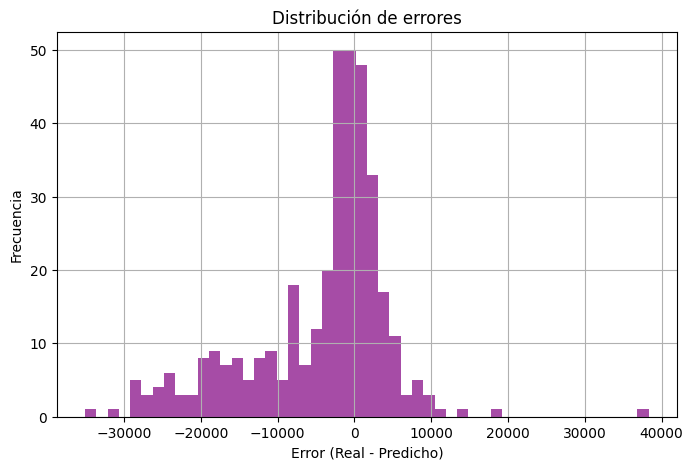

💾 Guardando ensemble final...
✅ Ensemble guardado en: ../../../modelos/ensemble_group.pkl

✅ PIPELINE COMPLETADO


In [5]:
# ensemble_group_pipeline.py
# ============================================================================
# ENSEMBLE MODEL CON GROUPKFold, VOTING POR FOLDS, GRÁFICOS Y GUARDADO
# ============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# ============================================================================
# FUNCIONES ORIGINALES (adaptar si es necesario)
# ============================================================================

def create_models(base_model):
    """Crea modelos base para ensemble"""
    print("⚙️ Creando modelos...")
    models = {
        'LightGBM': base_model,
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    return models

def train_models(models, X_train, y_train, X_test, y_test):
    """Entrena modelos individuales"""
    results = {}
    for name, model in models.items():
        print(f"🚀 Entrenando {name}...")
        if name != 'LightGBM':
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred
        }
        print(f"   ✅ RMSE: ${rmse:,.2f} | R²: {r2:.3f}")
    return results

# ============================================================================
# NUEVAS FUNCIONES PARA GROUPKFOLD
# ============================================================================

def train_models_group_folds(models, X, y, groups, n_splits=5, scaler=None):
    """Entrena modelos en folds definidos por grupos"""
    print("🔄 Entrenando modelos con GroupKFold...")
    gkf = GroupKFold(n_splits=n_splits)
    all_results = []

    for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n==== Fold {i+1}/{n_splits} ====")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado opcional
        if scaler is not None:
            scaler_fold = StandardScaler()
            X_train_scaled = scaler_fold.fit_transform(X_train)
            X_test_scaled = scaler_fold.transform(X_test)
        else:
            X_train_scaled, X_test_scaled, scaler_fold = X_train, X_test, None

        results_fold = train_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

        all_results.append({
            'results': results_fold,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler_fold
        })

    print("\n✅ Entrenamiento por folds completado")
    return all_results

def ensemble_group_predictions(all_results, method='mean'):
    """Combina predicciones finales de los folds"""
    print("\n🎯 Creando ensemble final de folds...")

    combined_preds = []
    combined_true = []

    for fold_data in all_results:
        fold_preds = []
        y_test = fold_data['y_test']
        X_test = fold_data['X_test']
        results = fold_data['results']
        scaler = fold_data['scaler']

        for name, res in results.items():
            model = res['model']
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X_test)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test)
            fold_preds.append(preds)

        if method == 'mean':
            fold_final = np.mean(fold_preds, axis=0)
        elif method == 'median':
            fold_final = np.median(fold_preds, axis=0)
        else:
            raise ValueError("Método no soportado. Usa 'mean' o 'median'.")

        combined_preds.append(fold_final)
        combined_true.append(y_test.values)

    final_preds = np.concatenate(combined_preds)
    final_true = np.concatenate(combined_true)

    rmse = np.sqrt(mean_squared_error(final_true, final_preds))
    r2 = r2_score(final_true, final_preds)

    print(f"✅ Ensemble final: RMSE=${rmse:,.2f}, R²={r2:.3f}")
    return final_preds, final_true, rmse, r2

def plot_results(y_true, y_pred):
    """Genera gráficos de resultados"""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Salario real")
    plt.ylabel("Salario predicho")
    plt.title("Predicho vs Real (Ensemble Final)")
    plt.grid(True)
    plt.show()

    # Distribución de errores
    errors = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color='purple', alpha=0.7)
    plt.xlabel("Error (Real - Predicho)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de errores")
    plt.grid(True)
    plt.show()

def save_ensemble_package(all_results, model_package, filename="../../../modelos/ensemble_group.pkl"):
    """Guarda ensemble final en formato compatible"""
    print("💾 Guardando ensemble final...")

    ensemble_components = {
        'fold_results': all_results,
        'ensemble_type': 'group_voting',
        'n_folds': len(all_results),
    }

    compatible_package = {
        'model': ensemble_components,
        'model_name': 'Ensemble_Group_Voting',
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'total_features': len(model_package['feature_names']),
        'has_statistical_features': True,
        'is_ensemble': True,
        'metrics': {}  # Puedes agregar métricas resumidas si querés
    }

    try:
        joblib.dump(compatible_package, filename)
        print(f"✅ Ensemble guardado en: {filename}")
    except Exception as e:
        print(f"❌ Error al guardar ensemble: {e}")

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    print("🚀 INICIANDO PIPELINE CON GROUPKFOLD, VOTING FINAL, GRÁFICOS Y GUARDADO")
    print("="*70)

    # ========================
    # Cargar datos y modelo base
    # ========================
    model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
    data = pd.read_csv('../../../dataC/imputado.csv').dropna()
    print(f"✅ Datos cargados: {data.shape}")

    # ========================
    # Preparar grupos y features
    # ========================
    for idx, row in data.iterrows():
        exp_group, age_group = pred.calculate_groups(
            age=row['Age'], 
            years_of_experience=row['Years_of_Experience'], 
            grouping_info=model_package['grouping_info']
        )
        data.at[idx, 'Exp_group'] = exp_group
        data.at[idx, 'Age_group'] = age_group

    X = data.drop('Salary', axis=1)
    y = data['Salary']

    X_features, _ = f_lgbm.create_features_with_stats(
        X,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )

    groups = data['Exp_group']

    # ========================
    # Crear y entrenar modelos
    # ========================
    models = create_models(model_package['model'])

    all_results = train_models_group_folds(models, X_features, y, groups=groups, n_splits=3, scaler=None)

    # ========================
    # Ensemble final por folds
    # ========================
    final_preds, final_true, final_rmse, final_r2 = ensemble_group_predictions(all_results, method='mean')

    print("\n🏆 RESULTADO FINAL:")
    print(f"   RMSE: ${final_rmse:,.2f}")
    print(f"   R²: {final_r2:.3f}")

    # ========================
    # Graficar resultados
    # ========================
    plot_results(final_true, final_preds)

    # ========================
    # Guardar ensemble
    # ========================
    save_ensemble_package(all_results, model_package)

    print("\n✅ PIPELINE COMPLETADO")

if __name__ == "__main__":
    main()

In [6]:
# andando correctamente

🚀 INICIANDO PIPELINE CON GROUPKFOLD, VOTING FINAL, GRÁFICOS Y GUARDADO
✅ Datos cargados: (366, 9)
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (PREDICT)...
   📥 Usando estadísticas pre-calculadas de TRAIN...
   ✅ Creadas 32 features estadísticos para producción
✅ Features totales para producción: 102
   - Originales: 70
   - Estadísticos: 32
⚙️ Creando modelos...
🔄 Entrenando modelos con GroupKFold...

==== Fold 1/3 ====
🚀 Entrenando LightGBM...
   ✅ RMSE: $7,486.06 | R²: 0.895
🚀 Entrenando XGBoost...
   ✅ RMSE: $26,307.85 | R²: -0.291
🚀 Entrenando RandomForest...
   ✅ RMSE: $27,548.11 | R²: -0.416
🚀 Entrenando CatBoost...
   ✅ RMSE: $22,293.95

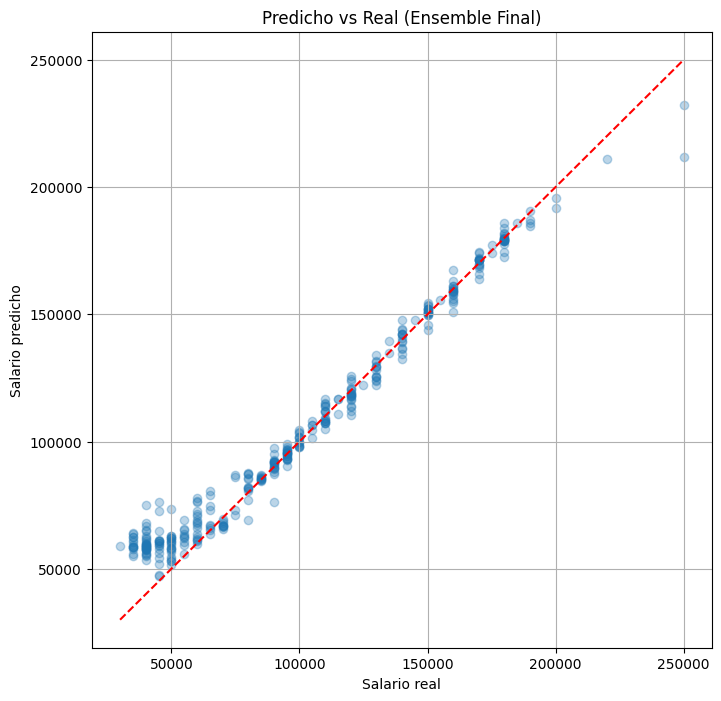

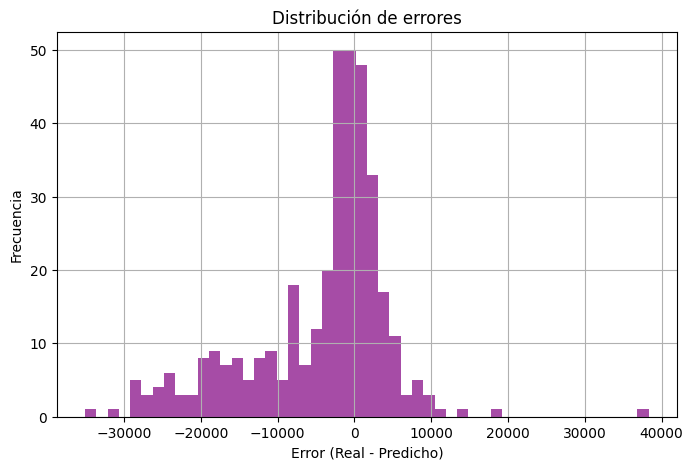

💾 Guardando ensemble final...
📊 Calculando métricas del ensemble...

🎯 Creando ensemble final de folds...
✅ Ensemble final: RMSE=$10,015.64, R²=0.957
✅ Ensemble guardado en: ../../../modelos/ensemble_group.pkl
📊 Métricas guardadas:
   📊 RMSE: $10,015.64
   📈 R²: 0.957
   📉 MAE: $6,519.15

✅ PIPELINE COMPLETADO


In [12]:
# ensemble_group_pipeline.py
# ============================================================================
# ENSEMBLE MODEL CON GROUPKFold, VOTING POR FOLDS, GRÁFICOS Y GUARDADO
# ============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# ============================================================================
# FUNCIONES ORIGINALES (adaptar si es necesario)
# ============================================================================

def create_models(base_model):
    """Crea modelos base para ensemble"""
    print("⚙️ Creando modelos...")
    models = {
        'LightGBM': base_model,
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    return models

def train_models(models, X_train, y_train, X_test, y_test):
    """Entrena modelos individuales"""
    results = {}
    for name, model in models.items():
        print(f"🚀 Entrenando {name}...")
        if name != 'LightGBM':
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred
        }
        print(f"   ✅ RMSE: ${rmse:,.2f} | R²: {r2:.3f}")
    return results

# ============================================================================
# NUEVAS FUNCIONES PARA GROUPKFOLD
# ============================================================================

def train_models_group_folds(models, X, y, groups, n_splits=5, scaler=None):
    """Entrena modelos en folds definidos por grupos"""
    print("🔄 Entrenando modelos con GroupKFold...")
    gkf = GroupKFold(n_splits=n_splits)
    all_results = []

    for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n==== Fold {i+1}/{n_splits} ====")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado opcional
        if scaler is not None:
            scaler_fold = StandardScaler()
            X_train_scaled = scaler_fold.fit_transform(X_train)
            X_test_scaled = scaler_fold.transform(X_test)
        else:
            X_train_scaled, X_test_scaled, scaler_fold = X_train, X_test, None

        results_fold = train_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

        all_results.append({
            'results': results_fold,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler_fold,
            'test_indices': test_idx  # ← AGREGADO: guardar los índices originales
        })

    print("\n✅ Entrenamiento por folds completado")
    return all_results

def ensemble_group_predictions(all_results, method='mean'):
    """Combina predicciones finales de los folds"""
    print("\n🎯 Creando ensemble final de folds...")

    combined_preds = []
    combined_true = []

    for fold_data in all_results:
        fold_preds = []
        y_test = fold_data['y_test']
        X_test = fold_data['X_test']
        results = fold_data['results']
        scaler = fold_data['scaler']

        for name, res in results.items():
            model = res['model']
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X_test)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test)
            fold_preds.append(preds)

        if method == 'mean':
            fold_final = np.mean(fold_preds, axis=0)
        elif method == 'median':
            fold_final = np.median(fold_preds, axis=0)
        else:
            raise ValueError("Método no soportado. Usa 'mean' o 'median'.")

        combined_preds.append(fold_final)
        combined_true.append(y_test.values)

    final_preds = np.concatenate(combined_preds)
    final_true = np.concatenate(combined_true)

    rmse = np.sqrt(mean_squared_error(final_true, final_preds))
    r2 = r2_score(final_true, final_preds)

    print(f"✅ Ensemble final: RMSE=${rmse:,.2f}, R²={r2:.3f}")
    return final_preds, final_true, rmse, r2

# ============================================================================
# NUEVA FUNCIÓN: ANÁLISIS DE ERRORES
# ============================================================================

def analyze_worst_predictions(all_results, data, n_worst=20):
    """
    Analiza los registros con mayor error absoluto porcentual
    
    Args:
        all_results: Resultados de todos los folds
        data: DataFrame original con información de los registros
        n_worst: Número de peores casos a mostrar
    """
    print(f"\n🔍 ANALIZANDO {n_worst} REGISTROS CON MAYOR ERROR ABSOLUTO %")
    print("=" * 80)
    
    # Recopilar todas las predicciones, valores reales e índices
    all_predictions = []
    all_true_values = []
    all_indices = []
    
    for fold_data in all_results:
        fold_preds = []
        y_test = fold_data['y_test']
        X_test = fold_data['X_test']
        results = fold_data['results']
        scaler = fold_data['scaler']
        test_indices = fold_data['test_indices']
        
        # Calcular ensemble para este fold
        for name, res in results.items():
            model = res['model']
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X_test)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test)
            fold_preds.append(preds)
        
        # Promedio de predicciones para este fold
        fold_ensemble = np.mean(fold_preds, axis=0)
        
        # Agregar a las listas totales
        all_predictions.extend(fold_ensemble)
        all_true_values.extend(y_test.values)
        all_indices.extend(test_indices)
    
    # Crear DataFrame con errores
    error_df = pd.DataFrame({
        'real': all_true_values,
        'prediccion': all_predictions,
        'error_absoluto': [abs(real - pred) for real, pred in zip(all_true_values, all_predictions)],
        'error_porcentual': [(abs(real - pred) / real) * 100 for real, pred in zip(all_true_values, all_predictions)],
        'original_index': all_indices
    })
    
    # Obtener los peores casos
    worst_cases = error_df.nlargest(n_worst, 'error_porcentual').copy()
    
    # Mostrar resultados detallados
    for i, (_, row) in enumerate(worst_cases.iterrows(), 1):
        try:
            # Convertir a entero para asegurar compatibilidad
            original_idx = int(row['original_index'])
            original_data = data.iloc[original_idx]
            
            print(f"\n🔸 Registro #{i} (Index original: {original_idx})")
            print(f"   💰 Salario Real: ${row['real']:,.2f}")
            print(f"   🎯 Predicción: ${row['prediccion']:,.2f}")
            print(f"   ❌ Error Absoluto: ${row['error_absoluto']:,.2f}")
            print(f"   📈 Error %: {row['error_porcentual']:.1f}%")
            print(f"   👤 Edad: {original_data['Age']:.0f} años")
            print(f"   🎓 Experiencia: {original_data['Years_of_Experience']:.0f} años")
            print(f"   💼 Trabajo: {original_data['Job_Title']}")
            
            # Mostrar campos adicionales si existen
            optional_fields = ['Company_Size', 'Location', 'Seniority_Level', 'Industry']
            for field in optional_fields:
                if field in original_data and pd.notna(original_data[field]):
                    icons = {'Company_Size': '🏢', 'Location': '📍', 'Seniority_Level': '🎖️', 'Industry': '🎨'}
                    print(f"   {icons.get(field, '📋')} {field.replace('_', ' ')}: {original_data[field]}")
            
        except Exception as e:
            print(f"\n⚠️ Error procesando registro #{i}: {e}")
            print(f"   Index problemático: {row['original_index']} (tipo: {type(row['original_index'])})")
            continue
        
        print("-" * 80)
    
    # Estadísticas resumidas
    print(f"\n📈 ESTADÍSTICAS DE ERRORES:")
    print(f"   Error promedio: {error_df['error_porcentual'].mean():.1f}%")
    print(f"   Error mediano: {error_df['error_porcentual'].median():.1f}%")
    print(f"   Error máximo: {error_df['error_porcentual'].max():.1f}%")
    print(f"   Error mínimo: {error_df['error_porcentual'].min():.1f}%")
    print(f"   Registros con errores margen: {(error_df['error_porcentual'] <= 15).sum()}")
    print(f"   Registros sin errores: {(error_df['error_porcentual'] == 0).sum()}")
    print(f"   Registros con error >10%: {(error_df['error_porcentual'] > 10).sum()}")
    print(f"   Registros con error >25%: {(error_df['error_porcentual'] > 25).sum()}")
    print(f"   Registros con error >50%: {(error_df['error_porcentual'] > 50).sum()}")
    print(f"   Registros con error >100%: {(error_df['error_porcentual'] > 100).sum()}")
    print(f"   Total de registros analizados: {len(error_df)}")
    
    return worst_cases

def plot_results(y_true, y_pred):
    """Genera gráficos de resultados"""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Salario real")
    plt.ylabel("Salario predicho")
    plt.title("Predicho vs Real (Ensemble Final)")
    plt.grid(True)
    plt.show()

    # Distribución de errores
    errors = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color='purple', alpha=0.7)
    plt.xlabel("Error (Real - Predicho)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de errores")
    plt.grid(True)
    plt.show()

def save_ensemble_package(all_results, model_package, filename="../../../modelos/ensemble_group.pkl"):
    """Guarda ensemble final en formato compatible CON MÉTRICAS"""
    print("💾 Guardando ensemble final...")
    
    # Calcular métricas del ensemble
    print("📊 Calculando métricas del ensemble...")
    final_preds, final_true, final_rmse, final_r2 = ensemble_group_predictions(all_results, method='mean')
    final_mae = np.mean(np.abs(final_true - final_preds))
    
    ensemble_components = {
        'fold_results': all_results,
        'ensemble_type': 'group_voting',
        'n_folds': len(all_results),
    }
    
    compatible_package = {
        'model': ensemble_components,
        'model_name': 'Ensemble_Group_Voting',
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'total_features': len(model_package['feature_names']),
        'has_statistical_features': True,
        'is_ensemble': True,
        'metrics': {
            'rmse': final_rmse,
            'r2': final_r2,
            'mae': final_mae
        }
    }
    
    try:
        joblib.dump(compatible_package, filename)
        print(f"✅ Ensemble guardado en: {filename}")
        print(f"📊 Métricas guardadas:")
        print(f"   📊 RMSE: ${final_rmse:,.2f}")
        print(f"   📈 R²: {final_r2:.3f}")
        print(f"   📉 MAE: ${final_mae:,.2f}")
    except Exception as e:
        print(f"❌ Error al guardar ensemble: {e}")

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    print("🚀 INICIANDO PIPELINE CON GROUPKFOLD, VOTING FINAL, GRÁFICOS Y GUARDADO")
    print("="*70)

    # ========================
    # Cargar datos y modelo base
    # ========================
    model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
    data = pd.read_csv('../../../dataC/imputado.csv').dropna()
    print(f"✅ Datos cargados: {data.shape}")

    # ========================
    # Preparar grupos y features
    # ========================
    for idx, row in data.iterrows():
        exp_group, age_group = pred.calculate_groups(
            age=row['Age'], 
            years_of_experience=row['Years_of_Experience'], 
            grouping_info=model_package['grouping_info']
        )
        data.at[idx, 'Exp_group'] = exp_group
        data.at[idx, 'Age_group'] = age_group

    X = data.drop('Salary', axis=1)
    y = data['Salary']

    X_features, _ = f_lgbm.create_features_with_stats(
        X,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )

    groups = data['Exp_group']

    # ========================
    # Crear y entrenar modelos
    # ========================
    models = create_models(model_package['model'])

    all_results = train_models_group_folds(models, X_features, y, groups=groups, n_splits=3, scaler=None)

    # ========================
    # Ensemble final por folds
    # ========================
    final_preds, final_true, final_rmse, final_r2 = ensemble_group_predictions(all_results, method='mean')

    print("\n🏆 RESULTADO FINAL:")
    print(f"   RMSE: ${final_rmse:,.2f}")
    print(f"   R²: {final_r2:.3f}")

    # ========================
    # ANÁLISIS DE LAS 20 PEORES PREDICCIONES
    # ========================
    print("\n" + "="*70)
    print("🔍 ANÁLISIS DE ERRORES")
    print("="*70)
    
    worst_cases = analyze_worst_predictions(all_results, data, n_worst=40)

    # ========================
    # Graficar resultados
    # ========================
    plot_results(final_true, final_preds)

    # ========================
    # Guardar ensemble
    # ========================
    save_ensemble_package(all_results, model_package)

    print("\n✅ PIPELINE COMPLETADO")
    
    # Retornar resultados para análisis adicional si es necesario
    return all_results, worst_cases

if __name__ == "__main__":
    results, errors = main()

🚀 INICIANDO PIPELINE DE ENSEMBLE REAL CON HOLD-OUT FINAL
✅ Datos cargados: (366, 9)
🔧 Preparando datos completos...

📊 DIVISIÓN PRINCIPAL DE DATOS:
   📚 Ensemble creation: 292 registros (79.8%)
   🧪 Final evaluation: 74 registros (20.2%)

🔧 PREPARANDO FEATURES PARA ENSEMBLE (292 registros):
🔧 Creando características completas para producción (originales + estadísticos)...
🔧 Creando todas las características ...
✅ Creadas 70 características en total
   - Variables numéricas básicas: 3
   - Variables de educación: 3
   - Variables de job category: 12
   - Variables de seniority: 6
   - Variables de texto: 4
   - Ratios y scores: 5
📊 Creando features estadísticos para producción (PREDICT)...
   📥 Usando estadísticas pre-calculadas de TRAIN...
   ✅ Creadas 32 features estadísticos para producción
✅ Features totales para producción: 102
   - Originales: 70
   - Estadísticos: 32
   ✅ Features creadas: (292, 102)
   ✅ Grupos únicos: 3

🔄 ENTRENAMIENTO CON GROUPKFOLD (validación internal):
⚙️ 

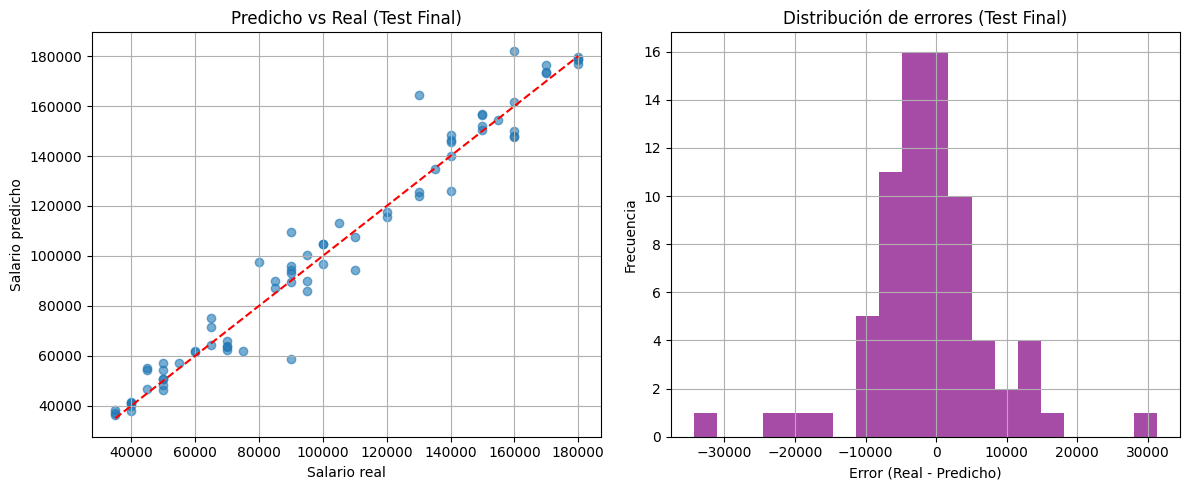

💾 Guardando ensemble real...
✅ Ensemble real guardado en: ../../../modelos/ensemble_real.pkl
📊 Métricas guardadas:
   📊 RMSE: $8,788.52
   📈 R²: 0.963

✅ PIPELINE DE ENSEMBLE REAL COMPLETADO
🎯 Evaluación final en 74 registros completamente no vistos


In [ ]:
# 
# ============================================================================
# ENSEMBLE  CON GROUPKFold + HOLD-OUT FINAL
# ============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')



def create_models(base_model):
    """Crea modelos base para ensemble"""
    print("⚙️ Creando modelos...")
    models = {
        'LightGBM': base_model,
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    return models

def train_models(models, X_train, y_train, X_test, y_test):
    """Entrena modelos individuales"""
    results = {}
    for name, model in models.items():
        print(f"🚀 Entrenando {name}...")
        if name != 'LightGBM':
            model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'predictions': y_pred
        }
        print(f"   ✅ RMSE: ${rmse:,.2f} | R²: {r2:.3f}")
    return results

# ============================================================================
# FUNCIONES PARA GROUPKFOLD (para crear ensemble)
# ============================================================================

def train_models_group_folds(models, X, y, groups, n_splits=3, scaler=None):
    """Entrena modelos en folds definidos por grupos SOLO para crear ensemble"""
    print("🔄 Entrenando modelos con GroupKFold para crear ensemble...")
    gkf = GroupKFold(n_splits=n_splits)
    all_results = []

    for i, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        print(f"\n==== Fold {i+1}/{n_splits} ====")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado opcional
        if scaler is not None:
            scaler_fold = StandardScaler()
            X_train_scaled = scaler_fold.fit_transform(X_train)
            X_test_scaled = scaler_fold.transform(X_test)
        else:
            X_train_scaled, X_test_scaled, scaler_fold = X_train, X_test, None

        results_fold = train_models(models, X_train_scaled, y_train, X_test_scaled, y_test)

        all_results.append({
            'results': results_fold,
            'X_test': X_test,
            'y_test': y_test,
            'scaler': scaler_fold,
            'test_indices': test_idx
        })

    print("\n✅ Entrenamiento por folds para ensemble completado")
    return all_results

def ensemble_group_predictions(all_results, method='mean'):
    """Combina predicciones de los folds (SOLO para validar ensemble creation)"""
    print("\n🎯 Validando ensemble creation...")

    combined_preds = []
    combined_true = []

    for fold_data in all_results:
        fold_preds = []
        y_test = fold_data['y_test']
        X_test = fold_data['X_test']
        results = fold_data['results']
        scaler = fold_data['scaler']

        for name, res in results.items():
            model = res['model']
            if name in ['Ridge', 'ElasticNet'] and scaler is not None:
                X_scaled = scaler.transform(X_test)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test)
            fold_preds.append(preds)

        if method == 'mean':
            fold_final = np.mean(fold_preds, axis=0)
        elif method == 'median':
            fold_final = np.median(fold_preds, axis=0)
        else:
            raise ValueError("Método no soportado. Usa 'mean' o 'median'.")

        combined_preds.append(fold_final)
        combined_true.append(y_test.values)

    final_preds = np.concatenate(combined_preds)
    final_true = np.concatenate(combined_true)

    rmse = np.sqrt(mean_squared_error(final_true, final_preds))
    r2 = r2_score(final_true, final_preds)

    print(f"✅ Validación ensemble creation: RMSE=${rmse:,.2f}, R²={r2:.3f}")
    return final_preds, final_true, rmse, r2

# ============================================================================
# NUEVAS FUNCIONES PARA ENSEMBLE REAL
# ============================================================================

def prepare_full_data(data, model_package):
    """Prepara todos los datos con grupos"""
    print("🔧 Preparando datos completos...")
    data_copy = data.copy()
    
    for idx, row in data_copy.iterrows():
        exp_group, age_group = pred.calculate_groups(
            age=row['Age'], 
            years_of_experience=row['Years_of_Experience'], 
            grouping_info=model_package['grouping_info']
        )
        data_copy.at[idx, 'Exp_group'] = exp_group
        data_copy.at[idx, 'Age_group'] = age_group
    
    return data_copy

def train_final_models(models, X_features, y, scaler=None):
    """Entrena modelos finales en todos los datos de ensemble"""
    print("🎯 Entrenando modelos finales en todos los datos de ensemble...")
    
    final_models = {}
    
    for name, model in models.items():
        print(f"   Entrenando {name} final...")
        try:
            if name != 'LightGBM':
                if scaler is not None and name in ['Ridge', 'ElasticNet']:
                    X_scaled = scaler.fit_transform(X_features)
                    model.fit(X_scaled, y)
                else:
                    model.fit(X_features, y)
            
            final_models[name] = model
            print(f"   ✅ {name} entrenado exitosamente")
            
        except Exception as e:
            print(f"   ❌ Error entrenando {name}: {e}")
    
    return final_models

def evaluate_final_ensemble(final_models, X_test_features, y_test, scaler=None):
    """Evalúa el ensemble final en datos completamente no vistos"""
    print("\n🧪 EVALUANDO ENSEMBLE FINAL EN DATOS NO VISTOS:")
    
    final_predictions = {}
    ensemble_preds = []
    
    for name, model in final_models.items():
        try:
            if scaler is not None and name in ['Ridge', 'ElasticNet']:
                X_scaled = scaler.transform(X_test_features)
                preds = model.predict(X_scaled)
            else:
                preds = model.predict(X_test_features)
            
            final_predictions[name] = preds
            ensemble_preds.append(preds)
            
            # Métricas individuales
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            r2 = r2_score(y_test, preds)
            print(f"   {name}: RMSE=${rmse:,.2f}, R²={r2:.3f}")
            
        except Exception as e:
            print(f"   ❌ Error evaluando {name}: {e}")
    
    if not ensemble_preds:
        raise ValueError("No se pudieron generar predicciones del ensemble")
    
    # Ensemble final (promedio)
    ensemble_final = np.mean(ensemble_preds, axis=0)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_final))
    ensemble_r2 = r2_score(y_test, ensemble_final)
    
    print(f"\n🏆 ENSEMBLE FINAL:")
    print(f"   RMSE: ${ensemble_rmse:,.2f}")
    print(f"   R²: {ensemble_r2:.3f}")
    print(f"   Evaluado en: {len(y_test)} registros COMPLETAMENTE NO VISTOS")
    
    return ensemble_final, ensemble_rmse, ensemble_r2, final_predictions

def analyze_final_test_errors(y_true, y_pred, full_data, test_indices, n_worst=20):
    """Analiza errores en el test final real"""
    print(f"\n🔍 ANALIZANDO {n_worst} PEORES ERRORES EN TEST FINAL:")
    print("="*80)
    
    error_df = pd.DataFrame({
        'real': y_true,
        'prediccion': y_pred,
        'error_absoluto': abs(y_true - y_pred),
        'error_porcentual': (abs(y_true - y_pred) / y_true) * 100,
        'original_index': test_indices
    })
    
    worst_cases = error_df.nlargest(n_worst, 'error_porcentual')
    
    for i, (_, row) in enumerate(worst_cases.iterrows(), 1):
        try:
            original_idx = int(row['original_index'])
            original_data = full_data.iloc[original_idx]
            
            print(f"\n🔸 Error #{i} (Index: {original_idx})")
            print(f"   💰 Real: ${row['real']:,.2f}")
            print(f"   🎯 Predicción: ${row['prediccion']:,.2f}")
            print(f"   ❌ Error Absoluto: ${row['error_absoluto']:,.2f}")
            print(f"   📈 Error %: {row['error_porcentual']:.1f}%")
            print(f"   👤 Edad: {original_data['Age']:.0f} años")
            print(f"   🎓 Experiencia: {original_data['Years_of_Experience']:.0f} años")
            print(f"   💼 Trabajo: {original_data['Job_Title']}")
            
            # Campos opcionales
            optional_fields = ['Company_Size', 'Location', 'Seniority_Level', 'Industry']
            for field in optional_fields:
                if field in original_data and pd.notna(original_data[field]):
                    icons = {'Company_Size': '🏢', 'Location': '📍', 'Seniority_Level': '🎖️', 'Industry': '🎨'}
                    print(f"   {icons.get(field, '📋')} {field.replace('_', ' ')}: {original_data[field]}")
            
        except Exception as e:
            print(f"\n⚠️ Error procesando registro #{i}: {e}")
            continue
        
        print("-" * 80)
    
    # Estadísticas del test final
    print(f"\n📈 ESTADÍSTICAS TEST FINAL ({len(error_df)} registros):")
    print(f"   Error promedio: {error_df['error_porcentual'].mean():.1f}%")
    print(f"   Error mediano: {error_df['error_porcentual'].median():.1f}%")
    print(f"   Error máximo: {error_df['error_porcentual'].max():.1f}%")
    print(f"   Error mínimo: {error_df['error_porcentual'].min():.1f}%")
    print(f"   Errores <10%: {(error_df['error_porcentual'] < 10).sum()}")
    print(f"   Errores 10-25%: {((error_df['error_porcentual'] >= 10) & (error_df['error_porcentual'] <= 25)).sum()}")
    print(f"   Errores >25%: {(error_df['error_porcentual'] > 25).sum()}")
    print(f"   Errores >50%: {(error_df['error_porcentual'] > 50).sum()}")
    
    return worst_cases

def plot_results(y_true, y_pred, title="Ensemble Final"):
    """Genera gráficos de resultados"""
    plt.figure(figsize=(12, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Salario real")
    plt.ylabel("Salario predicho")
    plt.title(f"Predicho vs Real ({title})")
    plt.grid(True)
    
    # Distribución de errores
    errors = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=20, color='purple', alpha=0.7)
    plt.xlabel("Error (Real - Predicho)")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de errores ({title})")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def save_ensemble_package(final_models, model_package, final_rmse, final_r2, filename="../../../modelos/ensemble_real.pkl"):
    """Guarda ensemble real en formato compatible"""
    print("💾 Guardando ensemble real...")
    
    final_mae = 0  # Calcular si es necesario
    
    ensemble_components = {
        'individual_models': final_models,
        'ensemble_type': 'real_ensemble',
        'training_method': 'groupkfold_holdout',
    }
    
    compatible_package = {
        'model': ensemble_components,
        'model_name': 'Real_Ensemble_GroupKFold',
        'feature_names': model_package['feature_names'],
        'job_categories': model_package['job_categories'],
        'seniority_categories': model_package['seniority_categories'],
        'stats_dict': model_package['stats_dict'],
        'grouping_info': model_package['grouping_info'],
        'total_features': len(model_package['feature_names']),
        'has_statistical_features': True,
        'is_ensemble': True,
        'is_real_ensemble': True,  # Flag especial
        'metrics': {
            'rmse': final_rmse,
            'r2': final_r2,
            'mae': final_mae
        }
    }
    
    try:
        joblib.dump(compatible_package, filename)
        print(f"✅ Ensemble real guardado en: {filename}")
        print(f"📊 Métricas guardadas:")
        print(f"   📊 RMSE: ${final_rmse:,.2f}")
        print(f"   📈 R²: {final_r2:.3f}")
    except Exception as e:
        print(f"❌ Error al guardar ensemble: {e}")

# ============================================================================
# MAIN PIPELINE PARA ENSEMBLE REAL
# ============================================================================

def main():
    print("🚀 INICIANDO PIPELINE DE ENSEMBLE REAL CON HOLD-OUT FINAL")
    print("="*70)

    # ========================
    # 1. CARGAR DATOS Y PREPARAR
    # ========================
    model_package = joblib.load("../../../modelos/salary_with_stats.pkl")
    data = pd.read_csv('../../../dataC/imputado.csv').dropna()
    print(f"✅ Datos cargados: {data.shape}")

    # Preparar datos completos
    data_prepared = prepare_full_data(data, model_package)
    X_full = data_prepared.drop('Salary', axis=1)
    y_full = data_prepared['Salary']

    # ========================
    # 2. DIVISIÓN PRINCIPAL: ENSEMBLE vs EVALUACIÓN FINAL
    # ========================
    print(f"\n📊 DIVISIÓN PRINCIPAL DE DATOS:")
    
    # Crear bins de salario para estratificación
    salary_bins = pd.qcut(y_full, q=5, labels=False, duplicates='drop')
    
    X_ensemble, X_final_test, y_ensemble, y_final_test, idx_ensemble, idx_final_test = train_test_split(
        X_full, y_full, range(len(X_full)), 
        test_size=0.2, 
        random_state=42,
        stratify=salary_bins
    )
    
    print(f"   📚 Ensemble creation: {len(X_ensemble)} registros ({len(X_ensemble)/len(X_full)*100:.1f}%)")
    print(f"   🧪 Final evaluation: {len(X_final_test)} registros ({len(X_final_test)/len(X_full)*100:.1f}%)")

    # ========================
    # 3. CREAR FEATURES Y PREPARAR DATOS DE ENSEMBLE
    # ========================
    print(f"\n🔧 PREPARANDO FEATURES PARA ENSEMBLE ({len(X_ensemble)} registros):")
    
    X_ensemble_features, _ = f_lgbm.create_features_with_stats(
        X_ensemble,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )
    
    groups_ensemble = X_ensemble['Exp_group']
    print(f"   ✅ Features creadas: {X_ensemble_features.shape}")
    print(f"   ✅ Grupos únicos: {groups_ensemble.nunique()}")

    # ========================
    # 4. ENTRENAR Y VALIDAR ENSEMBLE CON GROUPKFOLD
    # ========================
    print(f"\n🔄 ENTRENAMIENTO CON GROUPKFOLD (validación internal):")
    
    models = create_models(model_package['model'])
    ensemble_creation_results = train_models_group_folds(
        models, X_ensemble_features, y_ensemble, 
        groups=groups_ensemble, n_splits=3, scaler=None
    )
    
    # Validar ensemble creation
    validation_preds, validation_true, validation_rmse, validation_r2 = ensemble_group_predictions(
        ensemble_creation_results, method='mean'
    )

    # ========================
    # 5. ENTRENAR MODELOS FINALES EN TODOS LOS DATOS DE ENSEMBLE
    # ========================
    print(f"\n🎯 ENTRENAMIENTO FINAL DEL ENSEMBLE:")
    
    final_models = train_final_models(models, X_ensemble_features, y_ensemble, scaler=None)

    # ========================
    # 6. PREPARAR DATOS DE TEST FINAL
    # ========================
    print(f"\n🔬 PREPARANDO DATOS DE TEST FINAL:")
    
    X_final_test_features, _ = f_lgbm.create_features_with_stats(
        X_final_test,
        all_job_categories=model_package['job_categories'],
        all_seniority_levels=model_package['seniority_categories'],
        stats_dict=model_package['stats_dict'],
        is_training=False
    )
    
    print(f"   ✅ Test features: {X_final_test_features.shape}")

    # ========================
    # 7. EVALUACIÓN FINAL EN DATOS COMPLETAMENTE NO VISTOS
    # ========================
    ensemble_final, ensemble_rmse, ensemble_r2, individual_preds = evaluate_final_ensemble(
        final_models, X_final_test_features, y_final_test, scaler=None
    )

    # ========================
    # 8. ANÁLISIS DE ERRORES EN TEST FINAL
    # ========================
    worst_cases = analyze_final_test_errors(
        y_final_test, ensemble_final, data_prepared, idx_final_test, n_worst=20
    )

    # ========================
    # 9. COMPARACIÓN DE RESULTADOS
    # ========================
    print(f"\n📊 COMPARACIÓN DE RESULTADOS:")
    print(f"   🔄 Validación interna (GroupKFold): RMSE=${validation_rmse:,.2f}, R²={validation_r2:.3f}")
    print(f"   🧪 Test final (Hold-out): RMSE=${ensemble_rmse:,.2f}, R²={ensemble_r2:.3f}")
    
    difference = ensemble_rmse - validation_rmse
    if difference > 0:
        print(f"   📈 Test final es ${difference:,.2f} PEOR (normal, más conservador)")
    else:
        print(f"   📉 Test final es ${abs(difference):,.2f} MEJOR (inusual)")

    # ========================
    # 10. GRÁFICOS
    # ========================
    plot_results(y_final_test, ensemble_final, "Test Final")

    # ========================
    # 11. GUARDAR ENSEMBLE
    # ========================
    save_ensemble_package(final_models, model_package, ensemble_rmse, ensemble_r2)

    print(f"\n✅ PIPELINE DE ENSEMBLE REAL COMPLETADO")
    print(f"🎯 Evaluación final en {len(y_final_test)} registros completamente no vistos")
    
    return {
        'ensemble_models': final_models,
        'final_test_rmse': ensemble_rmse,
        'final_test_r2': ensemble_r2,
        'final_predictions': ensemble_final,
        'final_true': y_final_test,
        'worst_cases': worst_cases,
        'validation_rmse': validation_rmse,
        'validation_r2': validation_r2
    }

if __name__ == "__main__":
    results = main()

In [8]:
#pip freeze > requirements.txt